In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download adityamahimkar/iqothnccd-lung-cancer-dataset

Dataset URL: https://www.kaggle.com/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset
License(s): copyright-authors
 58% 115M/199M [00:00<00:00, 1.20GB/s]
100% 199M/199M [00:00<00:00, 869MB/s] 


In [ ]:
import os

base_dir = '/content/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/'
class_names = ['Bengin cases', 'Malignant cases', 'Normal cases']

for class_name in class_names:
    class_folder = os.path.join(base_dir, class_name);
    files = [f for f in os.listdir(class_folder)]
    print(len(files))

120
561
416


In [ ]:
import shutil
import random
from PIL import Image, ImageEnhance

# Reset output dir if already present
output_dir = "/kaggle/working/balanced_dataset"
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir)

# Define target count for each class after augmentation
target_count = 600
img_size = (512, 512)

# Define random transformations
def get_random_transform():
    options = [
        lambda img: img.transpose(Image.FLIP_LEFT_RIGHT),
        lambda img: img.transpose(Image.FLIP_TOP_BOTTOM),
        lambda img: img.rotate(random.uniform(-25, 25)),
        lambda img: ImageEnhance.Contrast(img).enhance(random.uniform(1.2, 1.8)),
        lambda img: ImageEnhance.Color(img).enhance(random.uniform(1.2, 2.0)),
        lambda img: ImageEnhance.Sharpness(img).enhance(random.uniform(1.5, 2.5))
    ]
    return random.choice(options)

def augment_and_save(class_name, target_count):
    class_src = os.path.join(base_dir, class_name)
    class_dst = os.path.join(output_dir, class_name)
    os.makedirs(class_dst)

    images = [f for f in os.listdir(class_src)]
    original_count = len(images)

    # Copy images to output_dir
    for img in images:
        shutil.copy(os.path.join(class_src, img), os.path.join(class_dst, img))

    # Check if original_count < target_count
    extra_needed = target_count - original_count
    if extra_needed <= 0:
        return

    print(f"Need to generate {extra_needed} new images for {class_name}")

    for i in range(extra_needed):
        img_name = random.choice(images)
        try:
            with Image.open(os.path.join(class_src, img_name)) as img:
                img = img.convert('RGB').resize(img_size)
                transformed_img = get_random_transform()(img)
                save_name = f"aug{i}_{img_name}"
                transformed_img.save(os.path.join(class_dst, save_name))
        except Exception as err:
            print(f"Error while augmenting: {err}")

for class_name in class_names:
    augment_and_save(class_name, target_count)

print("Augmentation complete for all classes!")

Need to generate 480 new images for Bengin cases
Need to generate 39 new images for Malignant cases
Need to generate 184 new images for Normal cases
Augmentation complete for all classes!


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG expects 224x224
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet means
                         [0.229, 0.224, 0.225])  # ImageNet std
])

dataset = datasets.ImageFolder(root="/kaggle/working/balanced_dataset", transform=data_transforms)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.vgg16(pretrained=True)

# Freeze all layers except classifier
for param in model.features.parameters():
    param.requires_grad = False

# Replace the classifier (VGG16 has 4096 → 1000 classes by default)
model.classifier[6] = nn.Linear(4096, 3)  # 3 classes: Bengin, Malignant, Normal

model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:03<00:00, 146MB/s]


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10
vgg_train_losses = []
vgg_train_accuracies = []
vgg_val_losses = []
vgg_val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    vgg_train_losses.append(epoch_loss)
    vgg_train_accuracies.append(epoch_acc)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    vgg_val_losses.append(val_loss / len(val_loader))
    vgg_val_accuracies.append(val_correct / val_total)

    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {vgg_val_losses[-1]:.4f}, Val Acc: {vgg_val_accuracies[-1]:.4f}")

Epoch 1, Train Loss: 0.5062, Train Acc: 0.7625, Val Loss: 0.2547, Val Acc: 0.8861
Epoch 2, Train Loss: 0.1779, Train Acc: 0.9250, Val Loss: 0.1507, Val Acc: 0.9444
Epoch 3, Train Loss: 0.0852, Train Acc: 0.9667, Val Loss: 0.1349, Val Acc: 0.9556
Epoch 4, Train Loss: 0.0827, Train Acc: 0.9674, Val Loss: 0.2172, Val Acc: 0.9111
Epoch 5, Train Loss: 0.0549, Train Acc: 0.9819, Val Loss: 0.1042, Val Acc: 0.9583
Epoch 6, Train Loss: 0.0252, Train Acc: 0.9924, Val Loss: 0.0830, Val Acc: 0.9694
Epoch 7, Train Loss: 0.0290, Train Acc: 0.9917, Val Loss: 0.1208, Val Acc: 0.9639
Epoch 8, Train Loss: 0.0237, Train Acc: 0.9931, Val Loss: 0.1597, Val Acc: 0.9417
Epoch 9, Train Loss: 0.0079, Train Acc: 0.9979, Val Loss: 0.0981, Val Acc: 0.9722
Epoch 10, Train Loss: 0.0013, Train Acc: 1.0000, Val Loss: 0.0667, Val Acc: 0.9750


VGG16 Evaluation Metrics:
Accuracy: 0.975
Precision: 0.9751
Recall: 0.975
F1 Score: 0.975


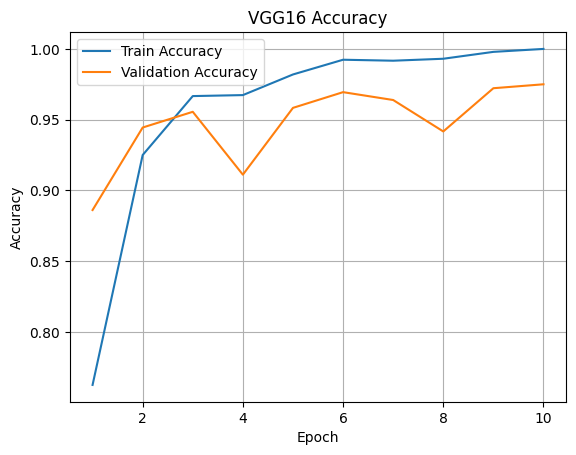

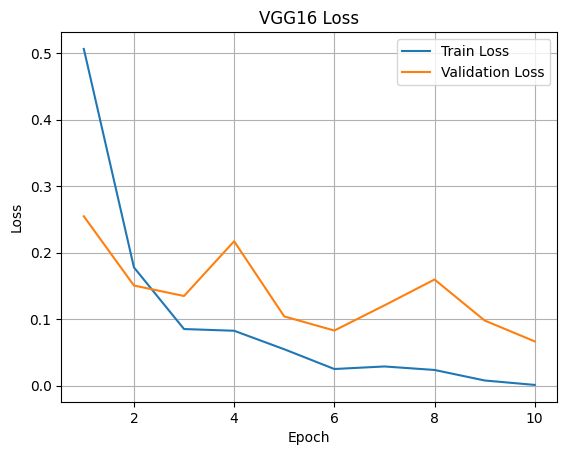

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import numpy as np
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

# Compute metrics
sklearn_accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Save to dictionary
vgg_metrics = {
    'Accuracy': round(sklearn_accuracy, 4),
    'Precision': round(precision, 4),
    'Recall': round(recall, 4),
    'F1 Score': round(f1, 4)
}

print("VGG16 Evaluation Metrics:")
for key, value in vgg_metrics.items():
    print(f"{key}: {value}")

# Accuracy plot
plt.plot(range(1, num_epochs+1), vgg_train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), vgg_val_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("VGG16 Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(range(1, num_epochs+1), vgg_train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), vgg_val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VGG16 Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
torch.save(model.state_dict(), "lung_cancer_model.pth")

NameError: name 'torch' is not defined